In [0]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.decomposition import FastICA
#from sklearn.random_projection import SparseRandomProjection
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.random_projection import GaussianRandomProjection
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [0]:
data_1=pd.read_csv("/kaggle/input/bankpromotion/bank-additional-full.csv",sep=";")
data_2=pd.read_csv("/kaggle/input/bankpromotion/bank-additional.csv",sep=";")
data=pd.concat([data_1,data_2],axis=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Text(0.5, 1, 'Variable Correlation')

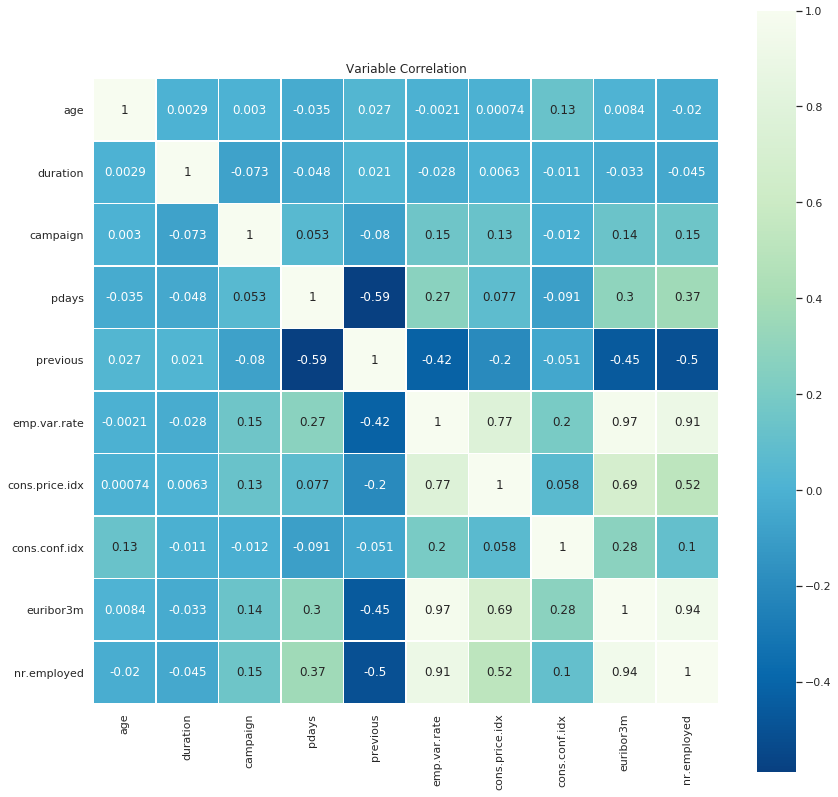

In [0]:
#Correlation Plot
plt.figure(figsize=(14,14))
sns.set(font_scale=1)
sns.heatmap(data.corr(),cmap='GnBu_r',annot=True, square = True ,linewidths=.5);
plt.title('Variable Correlation')

In [0]:
#To avoid mulicorinality drop the higly correltaed column
data = data.drop(["emp.var.rate","nr.employed"],axis=1)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,93.994,-36.4,4.857,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,93.994,-36.4,4.857,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,93.994,-36.4,4.857,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,93.994,-36.4,4.857,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,93.994,-36.4,4.857,no


In [0]:


#label encoding

jobDummies = pd.get_dummies(data['job'], prefix = 'job')
maritalDummies = pd.get_dummies(data['marital'], prefix = 'marital')
educationDummies = pd.get_dummies(data['education'], prefix = 'education')
defaultDummies = pd.get_dummies(data['default'], prefix = 'default')
housingDummies = pd.get_dummies(data['housing'], prefix = 'housing')
loanDummies = pd.get_dummies(data['loan'], prefix = 'loan')
contactDummies = pd.get_dummies(data['contact'], prefix = 'contact')
poutcomeDummies = pd.get_dummies(data['poutcome'], prefix = 'poutcome')
data['month']=data['month'].astype('category')
data['day_of_week']=data['day_of_week'].astype('category')
data['y']=data['y'].astype('category')

# Assigning numerical values and storing in another column
data['month'] = data['month'].cat.codes
data['day_of_week'] = data['day_of_week'].cat.codes
data['y'] = data['y'].cat.codes

data['y'].dtype



dtype('int8')

In [0]:
data["age"]=data["age"].astype("int")
data["duration"]=data["duration"].astype("int")
data["pdays"]=data["pdays"].astype("int")
data["previous"]=data["previous"].astype("int")
data["campaign"]=data["campaign"].astype("int")
data_int=data.select_dtypes(include=['int','float64','bool'])
#data_int
bank_df=pd.concat([data_int,jobDummies,maritalDummies,educationDummies,defaultDummies,housingDummies,loanDummies
                  ,contactDummies,poutcomeDummies,data['month'],data['day_of_week'],data['y']],axis=1)
bank_df.head()

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,job_admin.,job_blue-collar,...,loan_unknown,loan_yes,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,month,day_of_week,y
0,56,261,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
1,57,149,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
2,37,226,1,999,0,93.994,-36.4,4.857,0,0,...,0,0,0,1,0,1,0,6,1,0
3,40,151,1,999,0,93.994,-36.4,4.857,1,0,...,0,0,0,1,0,1,0,6,1,0
4,56,307,1,999,0,93.994,-36.4,4.857,0,0,...,0,1,0,1,0,1,0,6,1,0


In [0]:
#Total features after one-hot-encoding
features = bank_df.columns
len(features)

49

In [0]:


#Variables and Output
y=np.array(bank_df["y"])
X=np.array(bank_df.iloc[:,0:48])



# EM - Identify Clusters

In [0]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [0]:
n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X) 
        labels=gmm.predict(X)
        sil=silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

In [0]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [0]:
n_clusters=np.arange(2, 20)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X) 
        
        tmp_bic.append(gmm.bic(X))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

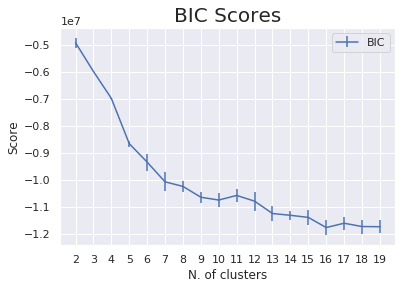

In [0]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

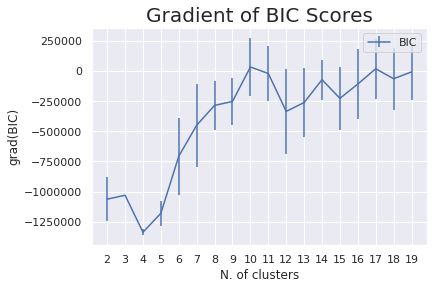

In [0]:

plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [0]:

# fit model
model = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
model.fit(X)
# predict latent values
yhat = model.predict(X)


In [0]:
s = silhouette_score(X, yhat)
print('Silhouette Score:', s)

Silhouette Score: 0.714372980384508


In [0]:

# fit model
model = GaussianMixture(n_components=3,covariance_type='tied',random_state=42)
model.fit(X)
# predict latent values
yhat = model.predict(X)

In [0]:
s = silhouette_score(X, yhat)
print('Silhouette Score:', s)

Silhouette Score: 0.7651916716622669


# PCA - EM

[6.56847580e-01 3.41670954e-01 1.06343975e-03 2.07113969e-04
 7.51425802e-05 5.25227929e-05 2.56822419e-05 1.88938423e-05
 4.79060387e-06 4.21212631e-06 3.48435939e-06 2.98854638e-06
 2.71867573e-06 2.57997050e-06]


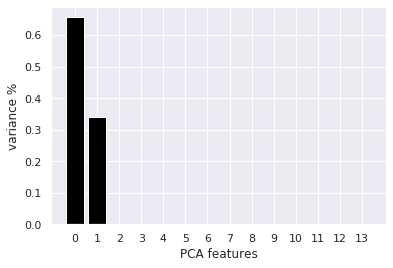

In [0]:
# Create a PCA instance: pca
pca = PCA(n_components=14)
principalComponents = pca.fit_transform(X)# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
print(pca.explained_variance_ratio_)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Text(0, 0.5, 'PCA 2')

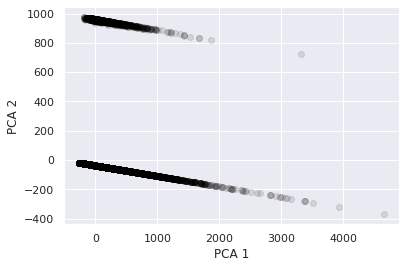

In [0]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [0]:
PCA_components.iloc[:,:2]

,0,1
0,0.215547,-36.782440
1,-111.496146,-28.752251
2,-34.698006,-34.310547
3,-109.504450,-28.928350
4,46.097183,-40.079961
...,...,...
45302,-207.253570,-21.938576
45303,-41.679321,-33.821248
45304,-196.281413,-22.727219
45305,266.528546,-55.920054


In [0]:
# fit model
model = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
model.fit(PCA_components.iloc[:,:2])
# predict latent values
yhat_pca = model.predict(PCA_components.iloc[:,:2])
yhat_prob_pca=model.predict_proba(PCA_components.iloc[:,:2])

In [0]:
s = silhouette_score(PCA_components.iloc[:,:2], yhat_pca)
print('Silhouette Score:', s)

Silhouette Score: 0.7174724027917543


Text(0.5, 1.0, 'EM - PCA')

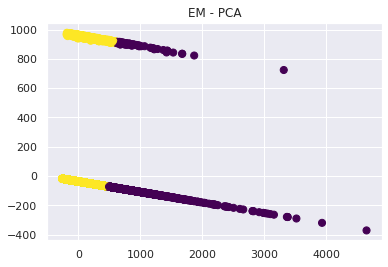

In [0]:
plt.scatter(PCA_components.iloc[:,0], PCA_components.iloc[:,1], c=yhat_pca, s=50, cmap='viridis')
plt.title('EM - PCA')

# Random Forest - EM

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [0]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [0]:
boolvec=sel.get_support()
boolvec.astype(bool)
boolvec

array([ True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True])

In [0]:
input_file=bank_df.iloc[:,0:48]
#X_RF=input_file.loc[:, sel.get_support()]
#input_file=sgemm_df.loc[:, sel.get_support()].head()
selected_feat= input_file.columns[(sel.get_support())]
#selected_feat = np.where(boolvec[:,None], X_train,X_train)
len(selected_feat)

10

In [0]:
print(selected_feat)
#sgemm_df

Index(['age', 'duration', 'campaign', 'pdays', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'poutcome_success', 'month',
       'day_of_week'],
      dtype='object')


In [0]:
X_RF=input_file.loc[:, sel.get_support()]

In [0]:
# fit model
model = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
model.fit(X_RF)
# predict latent values
yhat_rf = model.predict(X_RF)
yhat_prob_rf = model.predict(X_RF)

In [0]:
#labels=gmm.predict(X)
sil=silhouette_score(X_RF, yhat_rf, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.7174724027917543


# RCA

In [0]:
rca = GaussianRandomProjection(n_components=2, eps=0.1, random_state=42)
X_rca=rca.fit_transform(X)

In [0]:
# fit model
model = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
model.fit(X_rca)
# predict latent values
yhat_rca = model.predict(X_rca)
yhat_prob_rca = model.predict(X_rca)

In [0]:
#labels=gmm.predict(X)
sil=silhouette_score(X_rca, yhat_rca, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.7174724027917543


Text(0.5, 1.0, 'EM - RCA')

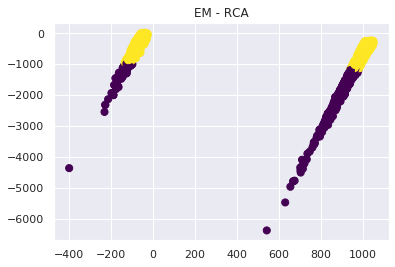

In [0]:
plt.scatter(X_rca[:, 0], X_rca[:, 1], c=yhat_rca, s=50, cmap='viridis')
plt.title('EM - RCA')

# ICA

In [0]:
ICA = FastICA(n_components=2, random_state=42) 
X_ica=ICA.fit_transform(X)

In [0]:
# fit model
model = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
model.fit(X_ica)
# predict latent values
yhat_ica = model.predict(X_ica)
yhat_prob_ica = model.predict(X_ica)

In [0]:
#labels=gmm.predict(X)
sil=silhouette_score(X_rca, yhat_ica, metric='euclidean')
print('Silhouette Score:', s)

Silhouette Score: 0.7174724027917543


Text(0.5, 1.0, 'EM - ICA')

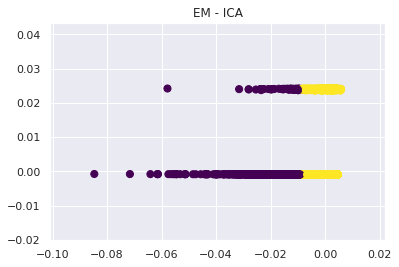

In [0]:
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=yhat_ica, s=50, cmap='viridis')
plt.title('EM - ICA')

# Neural Network on Cluster Output

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score
import time

Using TensorFlow backend.


In [0]:
X=np.array(yhat_prob_pca)
y=np.array(yhat_pca)

In [0]:
#Train Test Validation Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [0]:

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)
print(y_train_enc.shape)

(36245, 2)


In [0]:
# define the model
#get number of columns in training data
n_cols=X_train.shape[1]

# define model 1 layers
model = Sequential()
model.add(Dense(100, input_dim=n_cols, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
epochs= 100
start=time.time()
#fit model
hist=model.fit(X_train, y_train_enc,  validation_split=0.2, epochs=epochs,batch_size=100, verbose=1)
end=time.time()
print("Elapsed Time: ", end-start)

Train on 28996 samples, validate on 7249 samples
Epoch 1/100
28996/28996 [==============================] - 1s 24us/step - loss: 0.1835 - accuracy: 0.9941 - val_loss: 0.0230 - val_accuracy: 0.9983
Epoch 2/100
28996/28996 [==============================] - 0s 14us/step - loss: 0.0118 - accuracy: 0.9994 - val_loss: 0.0077 - val_accuracy: 0.9999
Epoch 3/100
28996/28996 [==============================] - 0s 14us/step - loss: 0.0053 - accuracy: 0.9998 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 4/100
28996/28996 [==============================] - 0s 13us/step - loss: 0.0036 - accuracy: 0.9999 - val_loss: 0.0038 - val_accuracy: 0.9999
Epoch 5/100
28996/28996 [==============================] - 0s 14us/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 0.0033 - val_accuracy: 0.9999
Epoch 6/100
28996/28996 [==============================] - 0s 13us/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.0029 - val_accuracy: 0.9999
Epoch 7/100
28996/28996 [==============================] - 0s 1

28996/28996 [==============================] - 0s 14us/step - loss: 4.7859e-04 - accuracy: 1.0000 - val_loss: 5.7037e-04 - val_accuracy: 0.9999
Epoch 55/100
28996/28996 [==============================] - 0s 13us/step - loss: 4.7510e-04 - accuracy: 0.9999 - val_loss: 5.6124e-04 - val_accuracy: 0.9999
Epoch 56/100
28996/28996 [==============================] - 0s 13us/step - loss: 4.7011e-04 - accuracy: 1.0000 - val_loss: 5.6471e-04 - val_accuracy: 0.9999
Epoch 57/100
28996/28996 [==============================] - 0s 13us/step - loss: 4.8522e-04 - accuracy: 0.9998 - val_loss: 5.4652e-04 - val_accuracy: 0.9999
Epoch 58/100
28996/28996 [==============================] - 0s 14us/step - loss: 4.9514e-04 - accuracy: 0.9999 - val_loss: 5.8090e-04 - val_accuracy: 1.0000
Epoch 59/100
28996/28996 [==============================] - 0s 13us/step - loss: 4.9175e-04 - accuracy: 1.0000 - val_loss: 5.3096e-04 - val_accuracy: 0.9999
Epoch 60/100
28996/28996 [==============================] - 0s 13us/ste

In [0]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=1)

9062/9062 [==============================] - 0s 13us/step


In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
#precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(y_test, yhat_classes)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_test, yhat_classes)
#print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000


In [0]:

# ROC AUC
auc = roc_auc_score(y_test_enc, yhat_probs)
print('ROC AUC: %f' % auc)


ROC AUC: 1.000000


In [0]:
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[ 490    0]
 [   0 8572]]


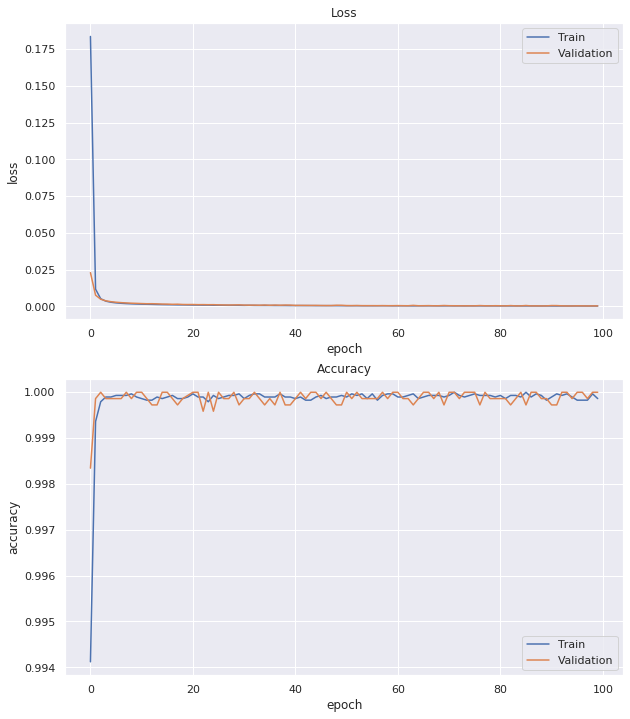

In [0]:

# plot loss during training
plt.figure(1, figsize=(10,12))
plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='Train')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()